## Connecting with Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')
#root_path = 'drive/My Drive/Lab/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Select current working directory or folder

In [2]:
import os
print("Current working directory: "+os.getcwd())
default_path = '/content/drive/My Drive/Lab/API'
os.chdir(default_path)
print("Current working directory: "+os.getcwd())

Current working directory: /content
Current working directory: /content/drive/My Drive/Lab/API


In [3]:
IMAGE_PATH = "/content/drive/My Drive/Lab/s10/"
MODEL_PATH = "/content/drive/My Drive/Lab/s10/"
# For Graph
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

## Import Support files and packages

In [4]:
from utils import *
#from image_transform import ImageTransform
from loader import Loader
from resnet import *
from graph_plot import *
from albumentation_transform import AlbumentationTransformations
from train import TrainModel
from test import TestModel
#from misclassified_images import MissclassifiedImages as ms
from display_images import *
#from correct_classified_images import CorrectclassifiedImages as cs
from albumentations import *
from albumentations.pytorch.transforms import ToTensor

## Setup device

In [5]:
# Device
SEED = 1
cuda = torch.cuda.is_available()
print("Cuda is available ?", cuda)
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

Cuda is available ? True


## Data augmentation, Dataset, DataLoader

In [6]:
img_mean = (0.4914, 0.4822, 0.4465)
img_std = (0.2023, 0.1994, 0.2010)

# Transforms
means = np.array(img_mean)
stdevs = np.array(img_std)
patch_size = 28

# Define Train transforms and Test transforms

transform_train = [
     # 
      #HorizontalFlip(p = 0.5),
      #GaussianBlur(),
      
      # RandomBrightnessContrast(),
      # HueSaturationValue(),
       #Downscale(),
      # RandomSizedCrop((patch_size,patch_size), patch_size,patch_size),      
      # RandomBrightness(),
       RandomContrast(),
      Cutout(num_holes=1, max_h_size=16, max_w_size=16, p=0.75),
      # RGBShift(),
     # RandomRotate90(),
      HorizontalFlip(p = 0.5),
      # MotionBlur(),   
      Normalize(mean=means, std=stdevs),
      ToTensor()
    ]

transform_test = [Normalize(mean=means, std=stdevs),
      ToTensor()
    ]

# Create Train transforms and Test transforms
t_transform_train =  AlbumentationTransformations(transform_train)
t_transform_test = AlbumentationTransformations(transform_test)

# Dataset and DataLoader arguments
dataset_name = torchvision.datasets.CIFAR10
trainSet_dict = dict(root='./data', train=True, download=True, transform=t_transform_train)
trainLoad_dict = dict(batch_size=64, shuffle=True, num_workers=2)
testSet_dict = dict(root='./data', train=False, download=True, transform=t_transform_test)
testLoad_dict = dict(batch_size=32, shuffle=False, num_workers=2)


# Create Train Loader and Test Loader
trainloader = Loader.getDataLoader(dataset_name, trainSet_dict, trainLoad_dict)
testloader = Loader.getDataLoader(dataset_name, testSet_dict, testLoad_dict)
classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Best Learning Rate Finder

########## Tweaked version from fastai ###########


: EPOCH= 1 Loss= 2.3627 Batch_id= 259 Accuracy= 9.78:  33%|███▎      | 259/782 [00:40<00:41, 12.49it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.42E-02


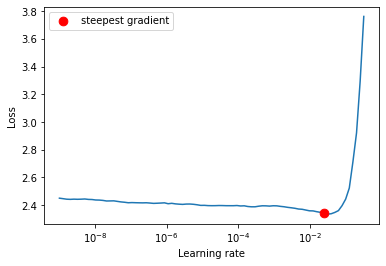

84
LR suggestion: steepest gradient
Suggested LR: 2.42E-02


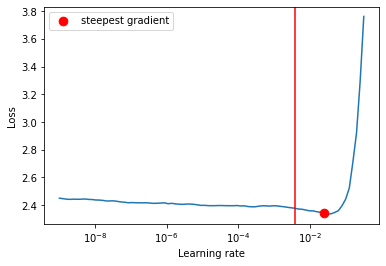

LR suggestion: steepest gradient
Suggested LR: 2.42E-02


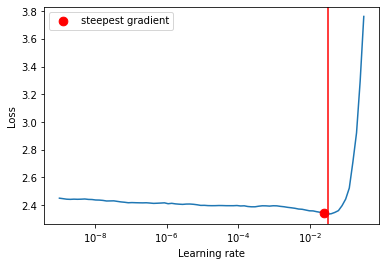

LR to be used: 0.009545484566618348


In [13]:

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-10, weight_decay=1e-2)
from find_LR import *
bestLR = get_LR(model, trainloader, optimizer, criterion, device)

## Hyperparameters

In [14]:
# Hyper parameters
LAMBDA1 = 1e-5
LR = bestLR
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4    #
EPOCHS = 50

## Loss Function, Optimizer and LR Scheduler

In [15]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# LR Scheduler
scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

## Model Summary (Layers and Parameter)

In [16]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Start training

In [17]:
filename = MODEL_PATH+"S10_model.pth"

In [18]:
for epoch in range(EPOCHS):
  train_loss, train_acc, i = TrainModel.train(model, device, trainloader, criterion, optimizer, epoch)
  # scheduler.step()
  train_losses.append(train_loss)
  train_accuracy.append(train_acc)
  test_loss, test_acc = TestModel.test(model, device, testloader, criterion)
  scheduler.step(test_loss)
  
  test_losses.append(test_loss)
  test_accuracy.append(test_acc)

  # Save Model
  state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
  torch.save(state, filename)

: EPOCH= 0 Loss= 1.5031 Batch_id= 781 Accuracy= 46.04: 100%|██████████| 782/782 [01:02<00:00, 12.53it/s]



Test set: Average Loss= 0.0330 Batch_id= 312 Accuracy= 6137/10000 (61.37%)



: EPOCH= 1 Loss= 1.0756 Batch_id= 781 Accuracy= 64.42: 100%|██████████| 782/782 [01:02<00:00, 12.55it/s]



Test set: Average Loss= 0.0287 Batch_id= 312 Accuracy= 6957/10000 (69.57%)



: EPOCH= 2 Loss= 0.7778 Batch_id= 781 Accuracy= 71.76: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]



Test set: Average Loss= 0.0220 Batch_id= 312 Accuracy= 7605/10000 (76.05%)



: EPOCH= 3 Loss= 0.4762 Batch_id= 781 Accuracy= 76.01: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]



Test set: Average Loss= 0.0203 Batch_id= 312 Accuracy= 7859/10000 (78.59%)



: EPOCH= 4 Loss= 0.6324 Batch_id= 781 Accuracy= 78.54: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]



Test set: Average Loss= 0.0169 Batch_id= 312 Accuracy= 8181/10000 (81.81%)



: EPOCH= 5 Loss= 0.6491 Batch_id= 781 Accuracy= 80.50: 100%|██████████| 782/782 [01:02<00:00, 12.55it/s]



Test set: Average Loss= 0.0170 Batch_id= 312 Accuracy= 8167/10000 (81.67%)



: EPOCH= 6 Loss= 0.5261 Batch_id= 781 Accuracy= 82.18: 100%|██████████| 782/782 [01:02<00:00, 12.52it/s]



Test set: Average Loss= 0.0153 Batch_id= 312 Accuracy= 8348/10000 (83.48%)



: EPOCH= 7 Loss= 0.5723 Batch_id= 781 Accuracy= 83.56: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s]



Test set: Average Loss= 0.0158 Batch_id= 312 Accuracy= 8294/10000 (82.94%)



: EPOCH= 8 Loss= 0.2602 Batch_id= 781 Accuracy= 84.73: 100%|██████████| 782/782 [01:02<00:00, 12.61it/s]



Test set: Average Loss= 0.0139 Batch_id= 312 Accuracy= 8472/10000 (84.72%)



: EPOCH= 9 Loss= 0.5013 Batch_id= 781 Accuracy= 85.26: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0141 Batch_id= 312 Accuracy= 8483/10000 (84.83%)



: EPOCH= 10 Loss= 0.4382 Batch_id= 781 Accuracy= 86.41: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0142 Batch_id= 312 Accuracy= 8461/10000 (84.61%)



: EPOCH= 11 Loss= 0.2270 Batch_id= 781 Accuracy= 87.20: 100%|██████████| 782/782 [01:02<00:00, 12.55it/s]



Test set: Average Loss= 0.0156 Batch_id= 312 Accuracy= 8429/10000 (84.29%)



: EPOCH= 12 Loss= 0.4515 Batch_id= 781 Accuracy= 87.97: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0146 Batch_id= 312 Accuracy= 8491/10000 (84.91%)



: EPOCH= 13 Loss= 1.1740 Batch_id= 781 Accuracy= 88.33: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]



Test set: Average Loss= 0.0126 Batch_id= 312 Accuracy= 8637/10000 (86.37%)



: EPOCH= 14 Loss= 0.2645 Batch_id= 781 Accuracy= 89.14: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0139 Batch_id= 312 Accuracy= 8568/10000 (85.68%)



: EPOCH= 15 Loss= 0.0536 Batch_id= 781 Accuracy= 89.67: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]



Test set: Average Loss= 0.0139 Batch_id= 312 Accuracy= 8576/10000 (85.76%)



: EPOCH= 16 Loss= 0.1357 Batch_id= 781 Accuracy= 90.16: 100%|██████████| 782/782 [01:02<00:00, 12.53it/s]



Test set: Average Loss= 0.0147 Batch_id= 312 Accuracy= 8515/10000 (85.15%)



: EPOCH= 17 Loss= 0.5336 Batch_id= 781 Accuracy= 90.90: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s]



Test set: Average Loss= 0.0162 Batch_id= 312 Accuracy= 8434/10000 (84.34%)



: EPOCH= 18 Loss= 0.3367 Batch_id= 781 Accuracy= 91.13: 100%|██████████| 782/782 [01:02<00:00, 12.56it/s]



Test set: Average Loss= 0.0120 Batch_id= 312 Accuracy= 8759/10000 (87.59%)



: EPOCH= 19 Loss= 0.2535 Batch_id= 781 Accuracy= 91.27: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0125 Batch_id= 312 Accuracy= 8706/10000 (87.06%)



: EPOCH= 20 Loss= 0.1557 Batch_id= 781 Accuracy= 91.66: 100%|██████████| 782/782 [01:01<00:00, 12.61it/s]



Test set: Average Loss= 0.0132 Batch_id= 312 Accuracy= 8730/10000 (87.30%)



: EPOCH= 21 Loss= 0.6419 Batch_id= 781 Accuracy= 92.25: 100%|██████████| 782/782 [01:01<00:00, 12.63it/s]



Test set: Average Loss= 0.0123 Batch_id= 312 Accuracy= 8770/10000 (87.70%)



: EPOCH= 22 Loss= 0.3342 Batch_id= 781 Accuracy= 92.22: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]



Test set: Average Loss= 0.0136 Batch_id= 312 Accuracy= 8673/10000 (86.73%)



: EPOCH= 23 Loss= 0.3083 Batch_id= 781 Accuracy= 92.54: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s]



Test set: Average Loss= 0.0131 Batch_id= 312 Accuracy= 8736/10000 (87.36%)



: EPOCH= 24 Loss= 0.1081 Batch_id= 781 Accuracy= 93.01: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s]



Test set: Average Loss= 0.0118 Batch_id= 312 Accuracy= 8808/10000 (88.08%)



: EPOCH= 25 Loss= 0.1609 Batch_id= 781 Accuracy= 93.07: 100%|██████████| 782/782 [01:02<00:00, 12.56it/s]



Test set: Average Loss= 0.0119 Batch_id= 312 Accuracy= 8807/10000 (88.07%)



: EPOCH= 26 Loss= 0.1255 Batch_id= 781 Accuracy= 93.21: 100%|██████████| 782/782 [01:01<00:00, 12.62it/s]



Test set: Average Loss= 0.0124 Batch_id= 312 Accuracy= 8758/10000 (87.58%)



: EPOCH= 27 Loss= 0.1013 Batch_id= 781 Accuracy= 93.38: 100%|██████████| 782/782 [01:02<00:00, 12.56it/s]



Test set: Average Loss= 0.0125 Batch_id= 312 Accuracy= 8822/10000 (88.22%)



: EPOCH= 28 Loss= 0.1971 Batch_id= 781 Accuracy= 93.54: 100%|██████████| 782/782 [01:02<00:00, 12.55it/s]



Test set: Average Loss= 0.0124 Batch_id= 312 Accuracy= 8807/10000 (88.07%)



: EPOCH= 29 Loss= 0.1646 Batch_id= 781 Accuracy= 93.63: 100%|██████████| 782/782 [01:02<00:00, 12.59it/s]



Test set: Average Loss= 0.0122 Batch_id= 312 Accuracy= 8809/10000 (88.09%)



: EPOCH= 30 Loss= 0.4540 Batch_id= 781 Accuracy= 93.86: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s]



Test set: Average Loss= 0.0132 Batch_id= 312 Accuracy= 8736/10000 (87.36%)



: EPOCH= 31 Loss= 0.1497 Batch_id= 781 Accuracy= 94.16: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]



Test set: Average Loss= 0.0123 Batch_id= 312 Accuracy= 8784/10000 (87.84%)



: EPOCH= 32 Loss= 0.1567 Batch_id= 781 Accuracy= 94.03: 100%|██████████| 782/782 [01:02<00:00, 12.61it/s]



Test set: Average Loss= 0.0124 Batch_id= 312 Accuracy= 8820/10000 (88.20%)



: EPOCH= 33 Loss= 0.2823 Batch_id= 781 Accuracy= 94.27: 100%|██████████| 782/782 [01:01<00:00, 12.62it/s]



Test set: Average Loss= 0.0116 Batch_id= 312 Accuracy= 8887/10000 (88.87%)



: EPOCH= 34 Loss= 0.0244 Batch_id= 781 Accuracy= 94.27: 100%|██████████| 782/782 [01:02<00:00, 12.52it/s]



Test set: Average Loss= 0.0113 Batch_id= 312 Accuracy= 8883/10000 (88.83%)



: EPOCH= 35 Loss= 0.3660 Batch_id= 781 Accuracy= 94.26: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]



Test set: Average Loss= 0.0133 Batch_id= 312 Accuracy= 8741/10000 (87.41%)



: EPOCH= 36 Loss= 0.3643 Batch_id= 781 Accuracy= 94.29: 100%|██████████| 782/782 [01:02<00:00, 12.55it/s]



Test set: Average Loss= 0.0126 Batch_id= 312 Accuracy= 8832/10000 (88.32%)



: EPOCH= 37 Loss= 0.1814 Batch_id= 781 Accuracy= 94.35: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]



Test set: Average Loss= 0.0123 Batch_id= 312 Accuracy= 8812/10000 (88.12%)



: EPOCH= 38 Loss= 0.0710 Batch_id= 781 Accuracy= 94.54: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0126 Batch_id= 312 Accuracy= 8802/10000 (88.02%)



: EPOCH= 39 Loss= 0.0499 Batch_id= 781 Accuracy= 94.44: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s]



Test set: Average Loss= 0.0124 Batch_id= 312 Accuracy= 8799/10000 (87.99%)



: EPOCH= 40 Loss= 0.0561 Batch_id= 781 Accuracy= 94.55: 100%|██████████| 782/782 [01:02<00:00, 12.52it/s]



Test set: Average Loss= 0.0122 Batch_id= 312 Accuracy= 8821/10000 (88.21%)



: EPOCH= 41 Loss= 0.6596 Batch_id= 781 Accuracy= 94.68: 100%|██████████| 782/782 [01:02<00:00, 12.57it/s]



Test set: Average Loss= 0.0120 Batch_id= 312 Accuracy= 8846/10000 (88.46%)



: EPOCH= 42 Loss= 0.1878 Batch_id= 781 Accuracy= 94.68: 100%|██████████| 782/782 [01:02<00:00, 12.56it/s]



Test set: Average Loss= 0.0115 Batch_id= 312 Accuracy= 8907/10000 (89.07%)



: EPOCH= 43 Loss= 0.0526 Batch_id= 781 Accuracy= 94.78: 100%|██████████| 782/782 [01:02<00:00, 12.60it/s]



Test set: Average Loss= 0.0127 Batch_id= 312 Accuracy= 8800/10000 (88.00%)



: EPOCH= 44 Loss= 0.1352 Batch_id= 781 Accuracy= 94.82: 100%|██████████| 782/782 [01:02<00:00, 12.58it/s]



Test set: Average Loss= 0.0121 Batch_id= 312 Accuracy= 8852/10000 (88.52%)



: EPOCH= 45 Loss= 0.0518 Batch_id= 781 Accuracy= 94.69: 100%|██████████| 782/782 [01:02<00:00, 12.54it/s]



Test set: Average Loss= 0.0115 Batch_id= 312 Accuracy= 8840/10000 (88.40%)



: EPOCH= 46 Loss= 0.0889 Batch_id= 781 Accuracy= 96.95: 100%|██████████| 782/782 [01:02<00:00, 12.53it/s]



Test set: Average Loss= 0.0091 Batch_id= 312 Accuracy= 9108/10000 (91.08%)



: EPOCH= 47 Loss= 0.2039 Batch_id= 781 Accuracy= 97.93: 100%|██████████| 782/782 [01:02<00:00, 12.61it/s]



Test set: Average Loss= 0.0089 Batch_id= 312 Accuracy= 9125/10000 (91.25%)



: EPOCH= 48 Loss= 0.0468 Batch_id= 781 Accuracy= 98.29: 100%|██████████| 782/782 [01:02<00:00, 12.56it/s]



Test set: Average Loss= 0.0089 Batch_id= 312 Accuracy= 9153/10000 (91.53%)



: EPOCH= 49 Loss= 0.0738 Batch_id= 781 Accuracy= 98.40: 100%|██████████| 782/782 [01:02<00:00, 12.53it/s]



Test set: Average Loss= 0.0088 Batch_id= 312 Accuracy= 9177/10000 (91.77%)



In [19]:
PATH = "/content/drive/My Drive/Lab/s10"

## Show and Save losses and accuracy Plot

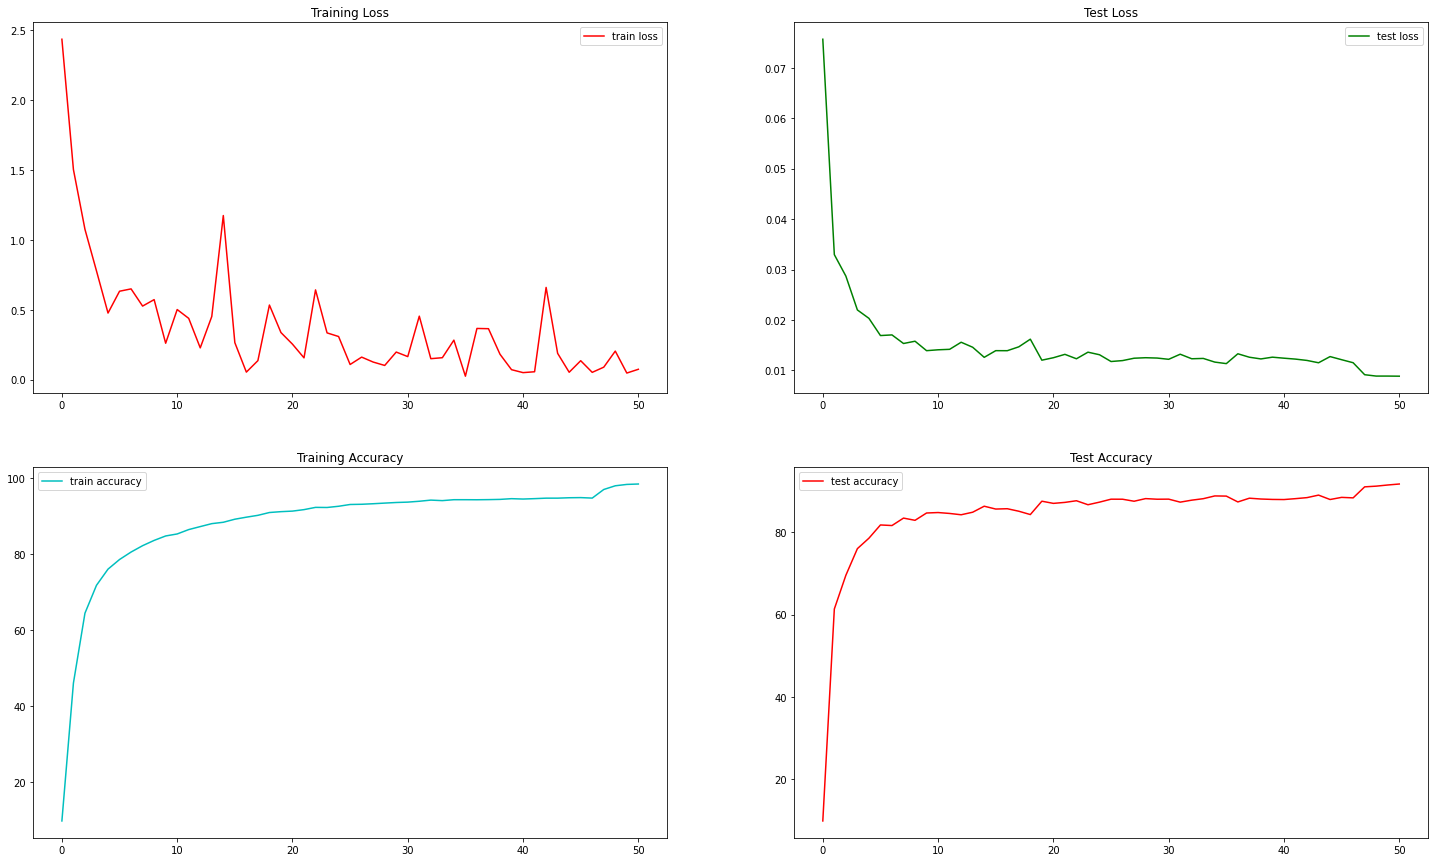

In [21]:
getPlottedGraph(EPOCHS+1, train_losses, train_accuracy, test_losses, test_accuracy,name="S10_plot", PATH=PATH+str("/visualization/"))

## Load model

In [22]:
def load_checkpoint(model, optimizer,  filename='checkpoint.pth.tar'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        # losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

In [23]:
model = ResNet18().to(device)
model, optimizer, start_epoch = load_checkpoint(model, optimizer,  filename)

=> loading checkpoint '/content/drive/My Drive/Lab/s10/S10_model.pth'
=> loaded checkpoint '/content/drive/My Drive/Lab/s10/S10_model.pth' (epoch 50)


## Show and Save correct classified images

/content/drive/My Drive/Lab/API/display_images.py:134: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_imgs_indexes = (pred.eq(target.view_as(pred)) == False).nonzero()[:, 0]


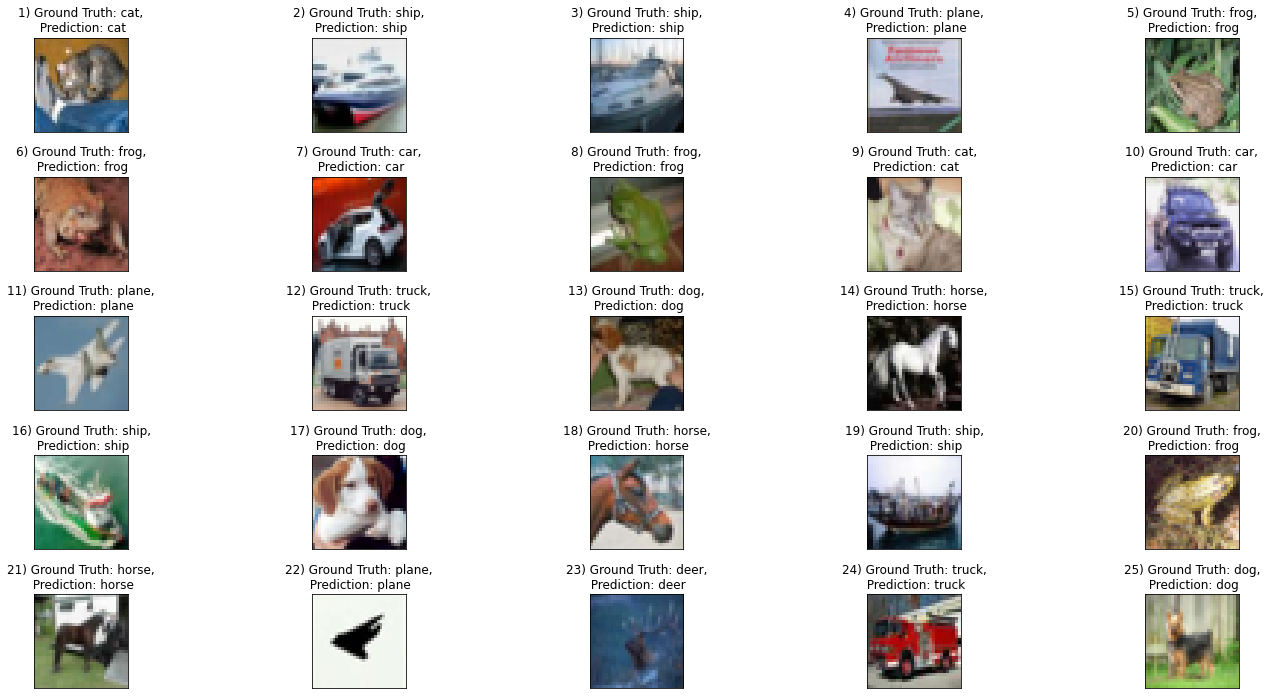

In [24]:
show_save_correctly_classified_images(model, testloader, device, PATH, name="correct_classified_imgs", max_correctly_classified_images_imgs=25,labels_list=classes)

## Show and Save misclassified images

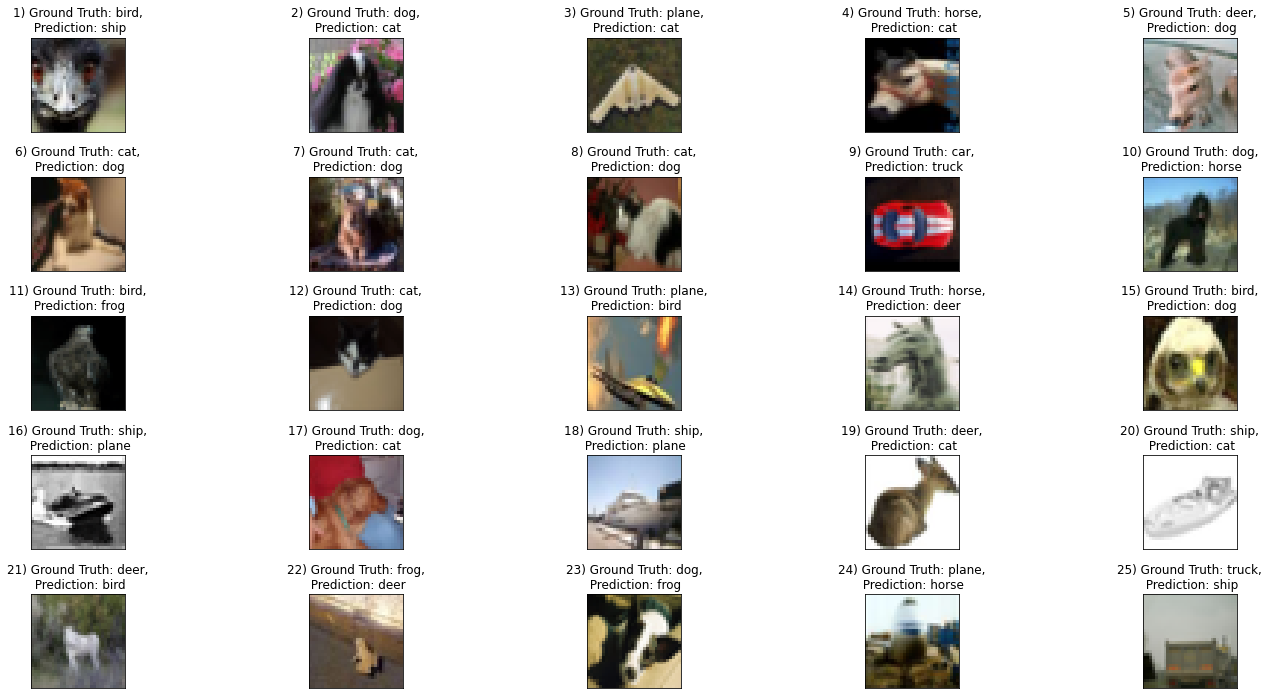

In [25]:
show_save_misclassified_images(model, testloader, device, PATH, name="misclassified_imgs", max_misclassified_imgs=25,labels_list=classes)

## Grad Cam

### Top 5 Correct classified image GradCam 

In [26]:
misclassified_imgs, correctly_classified_images = classify_images(model, testloader, device, 25)

In [27]:
from grad_cam import *

In [28]:
layers_list = ["layer1","layer2","layer3","layer4"]
display_gradcam = VisualizeCam(model, classes, layers_list)

### Top 5 misclassifeid image GradCam 

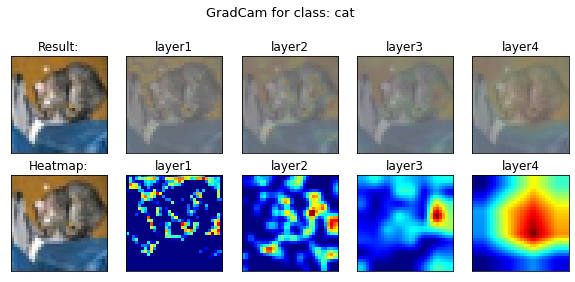

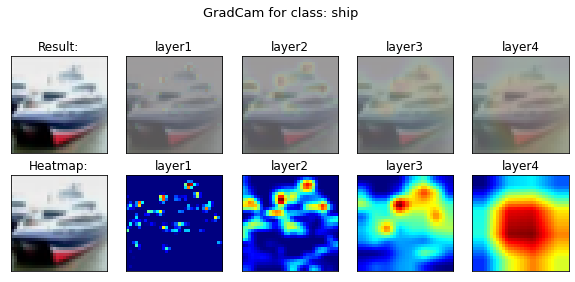

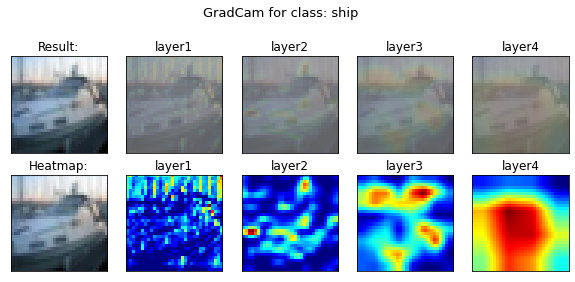

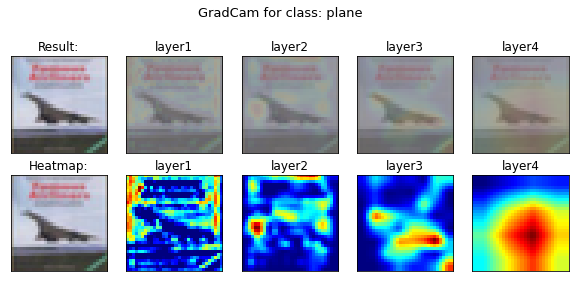

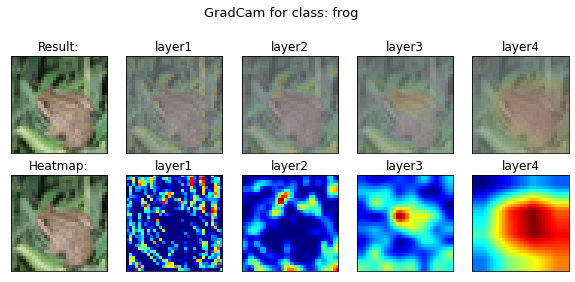

In [29]:
correct_pred_imgs = []
for i in range(len(correctly_classified_images)):
  correct_pred_imgs.append(torch.as_tensor(correctly_classified_images[i]["img"]))
display_gradcam(torch.stack(correct_pred_imgs), layers_list, PATH+str("/visualization"), metric="correct")

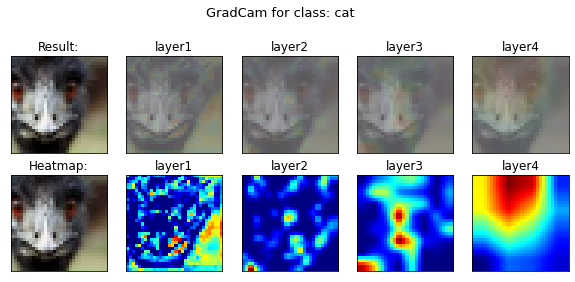

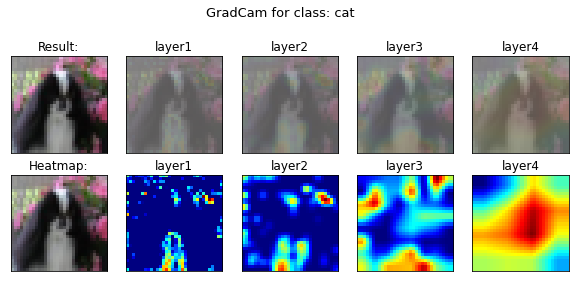

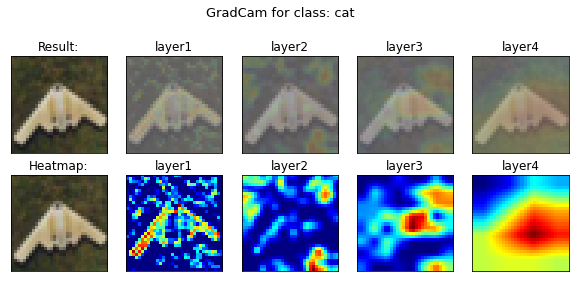

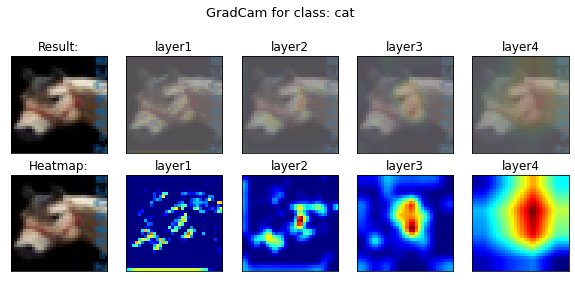

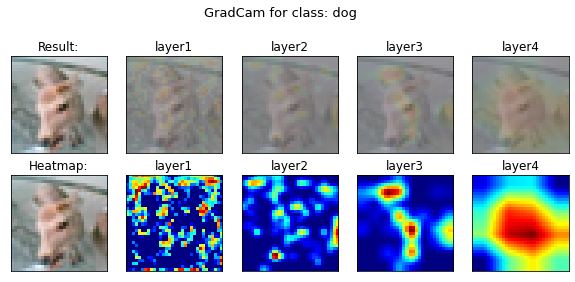

In [31]:
misclassify_pred_imgs = []
for i in range(len(misclassified_imgs)):
  misclassify_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
display_gradcam(torch.stack(misclassify_pred_imgs), layers_list, PATH+str("/visualization"), metric="misclassify")

### 25 misclassified images GradCam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

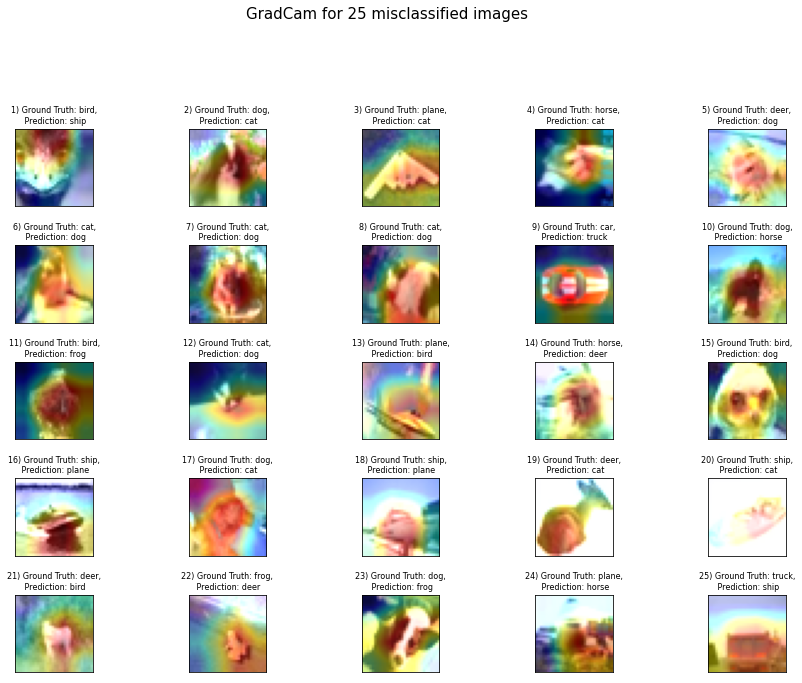

In [32]:
display_gradcam.plot_img_heatmap(misclassified_imgs, layers_list, PATH+"/visualization", target_inds=None, metric="", name="gradcam_misclassified_images")

In [ ]:
# # Train more
# for epoch in range(start_epoch, start_epoch+20):
#   train_loss, train_acc = TrainModel.train(model, device, trainloader, criterion, optimizer, epoch)
#   scheduler.step()
#   train_losses.append(train_loss)
#   train_accuracy.append(train_acc)
#   test_loss, test_acc = TestModel.test(model, device, testloader, criterion)
#   test_losses.append(test_loss)
#   test_accuracy.append(test_acc)

#   state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
#              'optimizer': optimizer.state_dict()}
#   torch.save(state, filename)